<a href="https://colab.research.google.com/github/hvmdvvn/Pytorch-Projects/blob/main/Audio_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'hKGAT_3a8bdd9649c59eb75bed0e309548341cttps://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hvmdvvn
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:26<00:00, 84.8MB/s]


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time

from skimage.transform import resize

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")
df.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [4]:
print(df["Class"].unique())

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']


In [5]:
print(len(df["Class"].unique()))

12


In [6]:
df["FilePath"] = '/content/quran-recitations-for-audio-classification/Dataset' + df["FilePath"].str[1:]
df.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


In [7]:
df['FilePath'].iloc[2]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

In [8]:
print("Data Shape: ", df.shape)
print("Class Distribution: ", df['Class'].value_counts())

Data Shape:  (6687, 2)
Class Distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


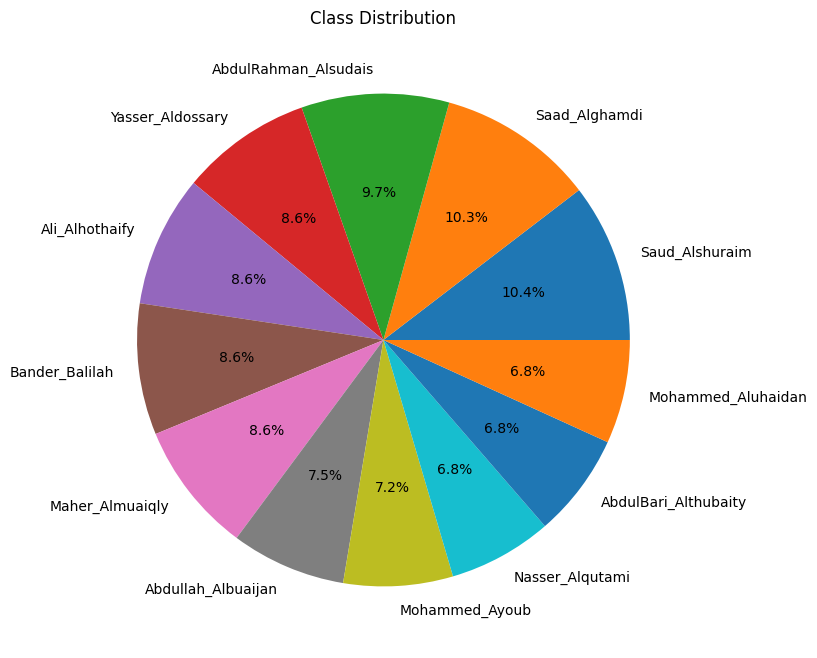

In [9]:
plt.figure(figsize=(8, 8))
plt.pie(df["Class"].value_counts(), labels=df["Class"].value_counts().index, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.show()

In [10]:
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

train = df.sample(frac=0.7, random_state = 7)
test = df.drop(train.index)

val = test.sample(frac=0.5, random_state = 7)
test = test.drop(val.index)

print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)
print("Val Shape: ", val.shape)

Train Shape:  (4681, 2)
Test Shape:  (1003, 2)
Val Shape:  (1003, 2)


In [11]:
class CustomAudioDataset(Dataset):
  def __init__(self, df):
    self.df = df
    self.labels = torch.Tensor(list(df["Class"])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in df["FilePath"]]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = self.audios[idx].unsqueeze(0).to(device)
    return audio, label

  def get_spectogram(self, file_path):
    sr =22050
    duration = 5

    img_height = 128
    img_width = 256

    signal, sr = librosa.load(file_path, sr=sr, duration=duration)

    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    spec_db = librosa.power_to_db(spec, ref=np.max)

    spec_resized = librosa.util.fix_length(spec_db, size=(duration*sr)//512+1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

    return spec_resized

In [12]:
train_dataset = CustomAudioDataset(train)
test_dataset = CustomAudioDataset(test)
val_dataset = CustomAudioDataset(val)

In [13]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear((64*16*32), 4096)
    self.linear2 = nn.Linear(4096, 1024)
    self.linear3 = nn.Linear(1024, 512)
    self.output = nn.Linear(512, 12)

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.pool(x)
    x = self.relu(x)

    x = x.view(x.size(0), -1)

    x = self.linear1(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = self.dropout(x)
    x = self.linear3(x)
    x = self.dropout(x)
    x = self.output(x)

    return x

In [24]:
model = Net().to(device)


In [25]:
from torchsummary import summary

summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
            Linear-8                 [-1, 4096]     134,221,824
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 1024]       4,195,328
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [27]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

In [30]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0

  for data in train_loader:
    inputs, labels = data

    optimizer.zero_grad()

    prediction = model(inputs)

    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    batch_loss.backward()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_train += acc

    optimizer.step()


  # Validation
  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data

      prediction = model(inputs)

      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()

      acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_validation/val_dataset.__len__() * 100, 4))

  print(f'''
  Epoch No. {epoch+1},
  Train Loss: {round(total_loss_train/1000, 4)},
  Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}.
  Validation Loss: {round(total_loss_validation/1000, 4)},
  Validation Accuracy: {round(total_acc_validation/val_dataset.__len__() * 100, 4)}
        ''')
  print('='*25)


  Epoch No. 1,
  Train Loss: 0.6178,
  Train Accuracy: 54.2619.
  Validation Loss: 0.0296,
  Validation Accuracy: 84.347
        

  Epoch No. 2,
  Train Loss: 0.1047,
  Train Accuracy: 88.9126.
  Validation Loss: 0.0184,
  Validation Accuracy: 90.2293
        

  Epoch No. 3,
  Train Loss: 0.0582,
  Train Accuracy: 93.6125.
  Validation Loss: 0.0204,
  Validation Accuracy: 91.2263
        

  Epoch No. 4,
  Train Loss: 0.0425,
  Train Accuracy: 95.2788.
  Validation Loss: 0.0181,
  Validation Accuracy: 90.7278
        

  Epoch No. 5,
  Train Loss: 0.0568,
  Train Accuracy: 94.1893.
  Validation Loss: 0.015,
  Validation Accuracy: 93.0209
        

  Epoch No. 6,
  Train Loss: 0.034,
  Train Accuracy: 96.6033.
  Validation Loss: 0.0202,
  Validation Accuracy: 91.0269
        

  Epoch No. 7,
  Train Loss: 0.0293,
  Train Accuracy: 97.116.
  Validation Loss: 0.0245,
  Validation Accuracy: 91.0269
        

  Epoch No. 8,
  Train Loss: 0.0269,
  Train Accuracy: 97.5005.
  Validation Lo

In [31]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in test_loader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)
    total_loss_test += batch_loss.item()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc


print(f"Accuracy: {round(total_acc_test/test_dataset.__len__() * 100, 4)} and Loss: {round(total_loss_test/1000, 4)}")

Accuracy: 93.9182 and Loss: 0.0197


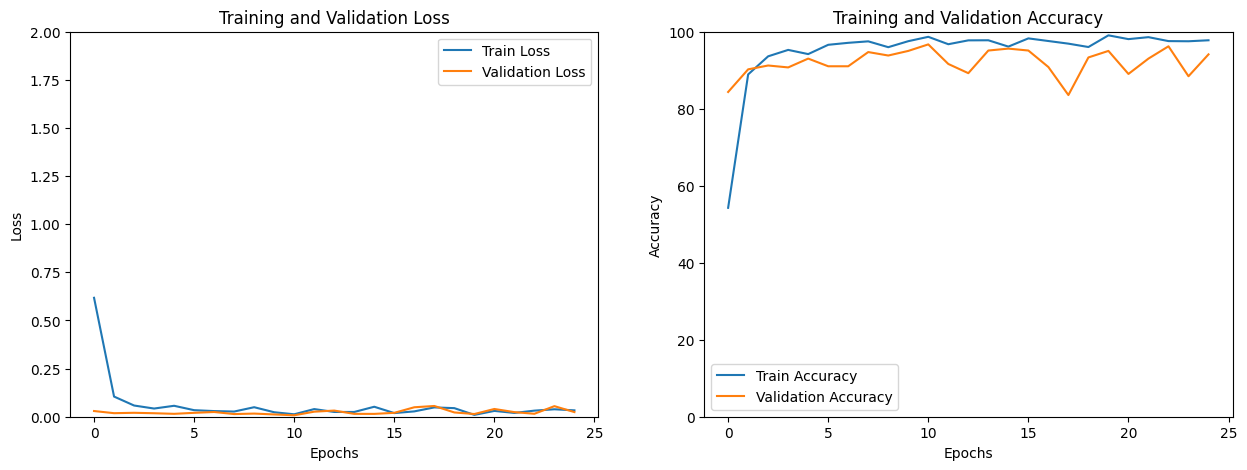

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = 'Train Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Train Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.show()